In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

In [2]:
# Функция для проверки качества модели и вывода метрик
def mod_check(X_train, y_train, X_test, y_test, model, show_auc = True):
    print('\n\nMetrics for model:')
    print(model, '\n\n')
    plt.close('all')
    model.fit(X_train, y_train) #
    y_pred = model.predict(X_train)
    classification_report = metrics.classification_report(y_train, y_pred)
    print('Отчет по обучению самой модели:')
    print(classification_report)
    disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_train, y_pred))
    
    disp.plot()
    plt.show()
    
    y_pred = model.predict(X_test)
    classification_report = metrics.classification_report(y_test, y_pred)
    print('\nОтчет по реализации модели:')
    print(classification_report)
    disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred))
    disp.plot()
    plt.show()
    
    
    if show_auc:
        proba = model.predict_proba(X_test)
        proba = proba[:,1]

        fpr, tpr, threshold = metrics.roc_curve(y_test, proba)
        roc_auc = metrics.roc_auc_score(y_test, proba)

        plt.figure()
        plt.plot([0, 1], label='Baseline', linestyle='--')
        plt.plot(fpr, tpr, label = 'Regression')
        plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.show()
        
    return metrics.f1_score(y_test, y_pred)

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

От даты подачи заявки и id клиента не зависит метрика default. Удалим их из датасета

In [5]:
data.drop(['client_id','app_date',], axis = 1, inplace=True)

In [6]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [7]:
# В educatoin заполняем пустые значения стринговыми переменными
data['education'].fillna('NaN', inplace = True)
data['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

# Обработка числовых признаков

<Figure size 432x288 with 0 Axes>

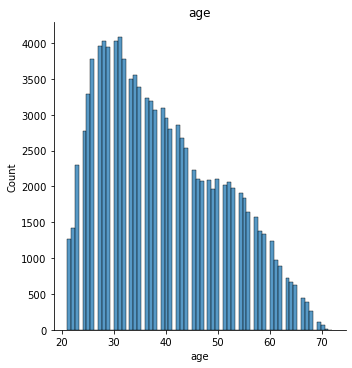

<Figure size 432x288 with 0 Axes>

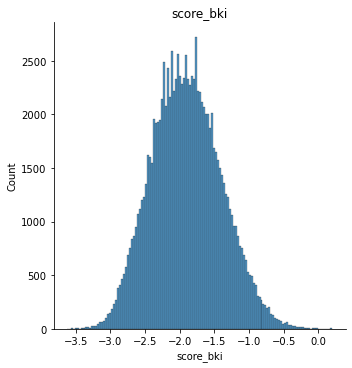

<Figure size 432x288 with 0 Axes>

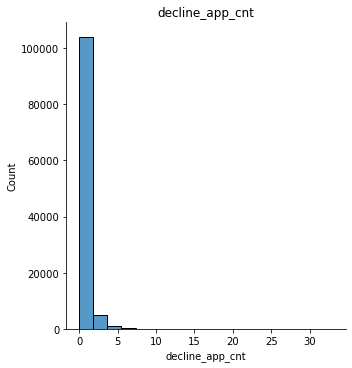

<Figure size 432x288 with 0 Axes>

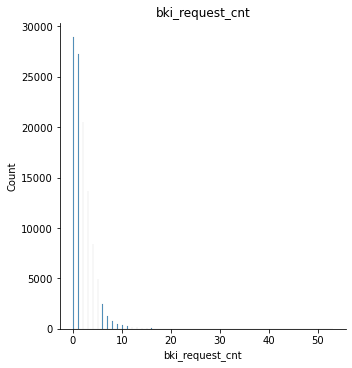

<Figure size 432x288 with 0 Axes>

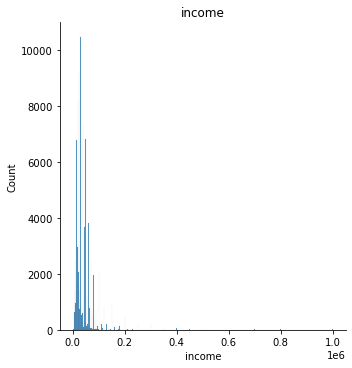

In [8]:
# Посмотрим на распределение числовых признаков
for i in num_cols:
    plt.figure()
    sns.displot(data[i], kde = False, rug=False)
    plt.title(i)
    plt.show()

Распределение не выглядит нормальным. Прологарифмируем числовые признаки, кроме score_bki

In [9]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

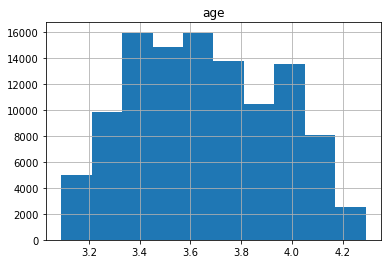

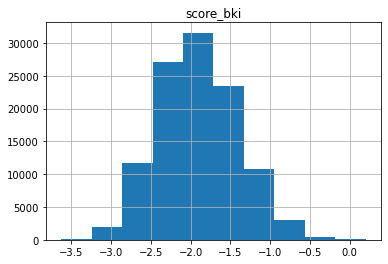

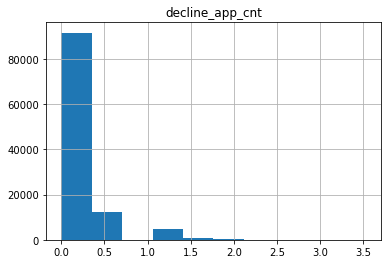

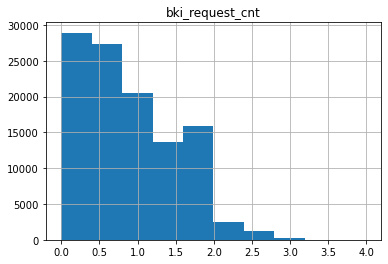

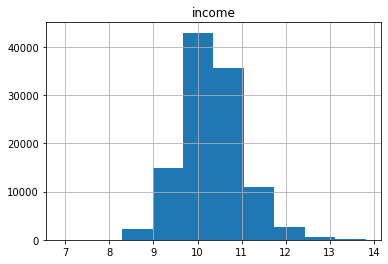

In [10]:
for i in num_cols_log:
    data[i] = np.log(data[i] + 1)
    
for i in num_cols:
    data[i].hist()
    plt.title(i)
    plt.show()

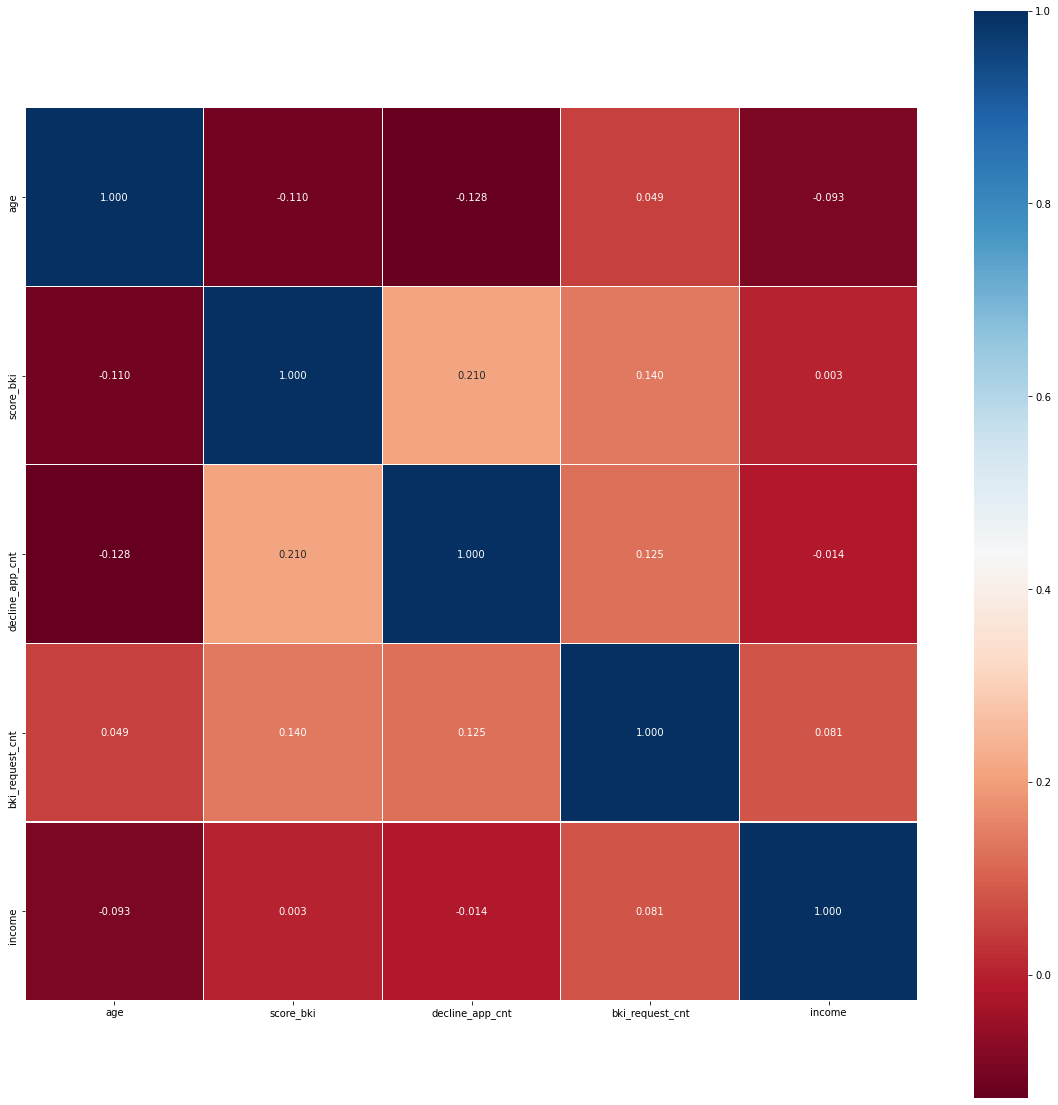

In [11]:
# Посмотрим матрицу корреляций
plt.subplots(figsize=(20, 20))
sns.heatmap(data[data['sample'] == 1][num_cols].corr(), square=True,
              annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu")
plt.show()

Сильно скоррелированных признаков нет, оставляем все

In [12]:
f_classif(data[data['sample'] == 1][num_cols], data[data['sample'] == 1]['default'].values)[0]

array([  50.3805738 , 2341.59944974, 1152.93731744,  457.59176046,
        214.7905274 ])

<AxesSubplot:>

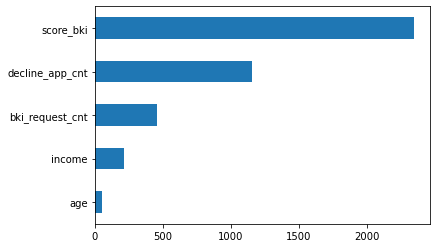

In [13]:
imp_num = pd.Series(f_classif(data[data['sample'] == 1][num_cols], data[data['sample'] == 1]['default'].values)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Обработка бинарных признаков

In [14]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,GRD,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,0,0
1,SCH,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,0,0
2,UGR,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1,0,0
3,SCH,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0,0,0
4,GRD,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,2,3,11.695255,1,3,0,0,0


# Обработка категориальных признаков

In [15]:
data['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

In [16]:
# Создаем словарь для колонки образования
ed = {'NaN' : 0, 'SCH' : 1, 'GRD' : 2, 'UGR' : 3, 'PGR' : 4, 'ACD' : 5}

In [17]:
data['education'].replace(ed, inplace = True)

<AxesSubplot:>

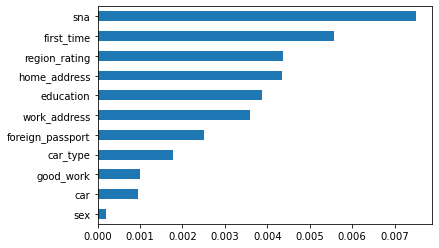

In [18]:
# Для оценки значимости категориальных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn
imp_cat = pd.Series(mutual_info_classif(data[data['sample'] == 1][bin_cols + cat_cols], data[data['sample'] == 1]['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [19]:
# Для дальнейшего преобразования ДФ, вернем изначальные значения education
edb = {0 : 'NaN', 1 : 'SCH', 2 : 'GRD', 3 : 'UGR', 4 : 'PGR', 5 : 'ACD'}
data['education'].replace(edb, inplace = True)
data['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

# Подготовка данных для модели

In [20]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1)

# выделим 20% данных на валидацию (параметр test_size)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Обрабатываем категориальные признаки для модели через OneHotEncoder с созданием экземпляра класса для применения текстовых данных
D_encoder = OneHotEncoder(sparse = False)
D_encoder.fit(X[cat_cols].values)
X_cat = D_encoder.transform(X[cat_cols].values)

In [22]:
# Стандартизация числовых переменных
scaler = StandardScaler()
scaler.fit(X[num_cols].values)

X_num = scaler.transform(X[num_cols].values)

In [23]:
X = np.hstack([X_num, X[bin_cols].values, X_cat])

In [24]:
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
f1 = {} # словарь для хранения основной метрики модели

# Logistic Regression



Metrics for model:
LogisticRegression(max_iter=1000, solver='liblinear') 


Отчет по обучению самой модели:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     51494
           1       0.49      0.03      0.05      7545

    accuracy                           0.87     59039
   macro avg       0.68      0.51      0.49     59039
weighted avg       0.83      0.87      0.82     59039



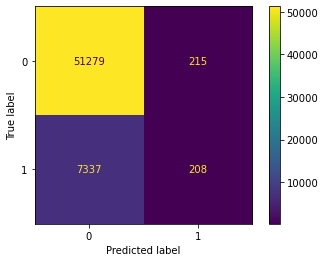


Отчет по реализации модели:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     12933
           1       0.44      0.02      0.04      1827

    accuracy                           0.88     14760
   macro avg       0.66      0.51      0.49     14760
weighted avg       0.82      0.88      0.82     14760



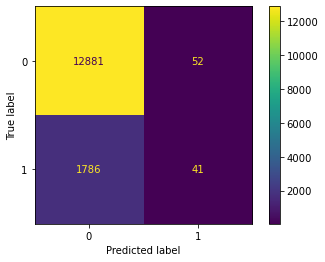

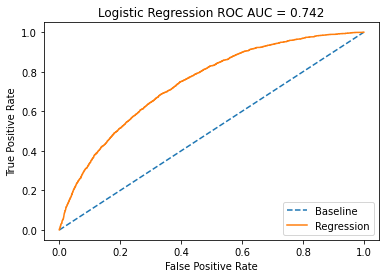

In [26]:
logreg = LogisticRegression(solver='liblinear', max_iter=1000)
f1['f1_model_logreg'] = mod_check(X_train, y_train, X_test, y_test, logreg)

# Logistic Regression with Post Predict

In [27]:
# Создаем столбец, который будет содержать вероятность default, предсказанную по логической регрессии
train_data['proba'] = logreg.predict_proba(X)[:,1]
# Создаем столбец, который будет содержать предсказанный default по логической регрессии
train_data['predict'] = logreg.predict(X)
# Посмотрим на средний результат для тех, у кого в реальности нет дефолта
train_data[train_data['default'] == 0][['proba', 'predict']].mean()

proba      0.116912
predict    0.004144
dtype: float64

In [28]:
# Посмотрим на средний результат для тех, у кого в реальности есть дефолт
train_data[train_data['default'] == 1][['proba', 'predict']].mean()

proba      0.201857
predict    0.026569
dtype: float64

In [29]:
treshold = (train_data[train_data['default'] == 1]['proba'].mean() + train_data[train_data['default'] == 0]['proba'].mean()) / 2

              precision    recall  f1-score   support

           0       0.93      0.76      0.84     12933
           1       0.25      0.57      0.35      1827

    accuracy                           0.74     14760
   macro avg       0.59      0.66      0.59     14760
weighted avg       0.84      0.74      0.78     14760



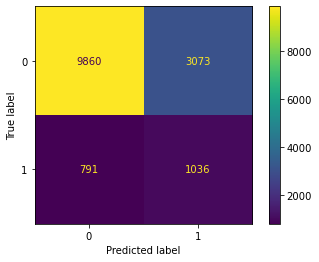

In [30]:
predict_proba = logreg.predict_proba(X_test)[:, 1]
predict = []
for item in predict_proba:
    if item > treshold:
        predict.append(1)
    else:
        predict.append(0)
classification_report = metrics.classification_report(y_test, predict)
print(classification_report)
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, predict))
disp.plot()
plt.show()
f1['f1_model_logreg_post'] = metrics.f1_score(y_test, predict)


# Logistic Regression with SMOTE



Metrics for model:
LogisticRegression(max_iter=1000, solver='liblinear') 


Отчет по обучению самой модели:
              precision    recall  f1-score   support

           0       0.68      0.67      0.67     51494
           1       0.67      0.69      0.68     51494

    accuracy                           0.68    102988
   macro avg       0.68      0.68      0.68    102988
weighted avg       0.68      0.68      0.68    102988



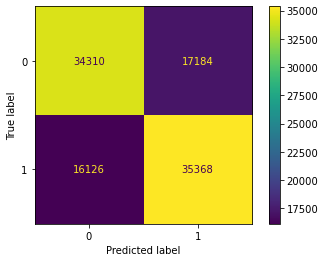


Отчет по реализации модели:
              precision    recall  f1-score   support

           0       0.94      0.66      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.72     14760



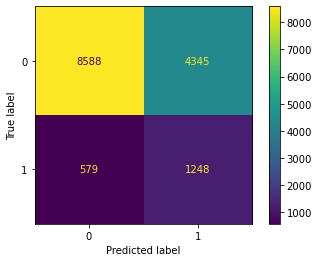

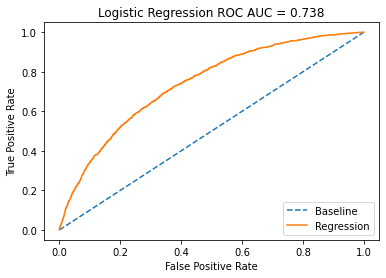

In [31]:
#В SMOTE (Способ Передискретизации Синтезированных Меньшинств) мы создаём элементы в непосредственной близости от 
#уже существующих в меньшем наборе.
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
logreg_smote = LogisticRegression(solver='liblinear', max_iter=1000)
f1['f1_model_logreg_sm'] = mod_check(X_train_smote, y_train_smote, X_test, y_test, logreg_smote)

# SVM model with SMOTE

In [32]:
#model_svm_sm = svm.SVC(kernel='linear', C=1)
#f1['f1_model_svm_sm'] = mod_check(X_train_smote, y_train_smote, X_test, y_test, model_svm_sm, show_auc = False)


# Tree classifier



Metrics for model:
DecisionTreeClassifier(random_state=42) 


Отчет по обучению самой модели:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51494
           1       1.00      1.00      1.00      7545

    accuracy                           1.00     59039
   macro avg       1.00      1.00      1.00     59039
weighted avg       1.00      1.00      1.00     59039



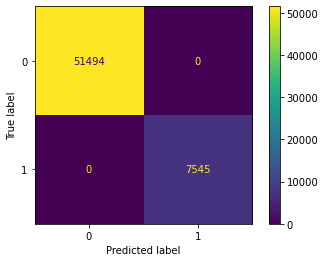


Отчет по реализации модели:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     12933
           1       0.19      0.24      0.21      1827

    accuracy                           0.78     14760
   macro avg       0.54      0.55      0.54     14760
weighted avg       0.80      0.78      0.79     14760



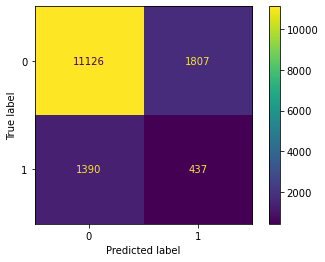

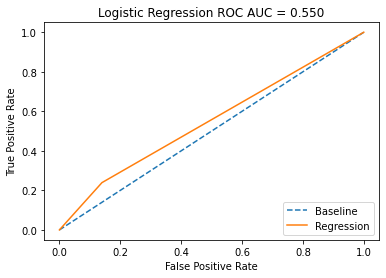

In [33]:
clf = DecisionTreeClassifier(random_state=42)
f1['f1_model_clf'] = mod_check(X_train, y_train, X_test, y_test, clf)

# Tree classifier with SMOTE reg



Metrics for model:
DecisionTreeClassifier(max_depth=10, random_state=42) 


Отчет по обучению самой модели:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75     51494
           1       0.75      0.77      0.76     51494

    accuracy                           0.76    102988
   macro avg       0.76      0.76      0.76    102988
weighted avg       0.76      0.76      0.76    102988



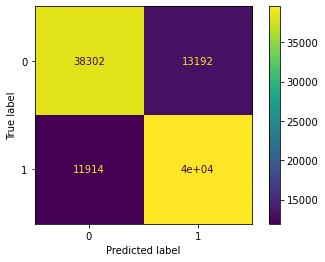


Отчет по реализации модели:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82     12933
           1       0.22      0.53      0.32      1827

    accuracy                           0.71     14760
   macro avg       0.57      0.64      0.57     14760
weighted avg       0.83      0.71      0.76     14760



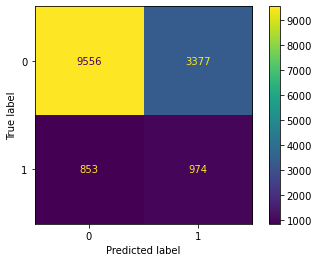

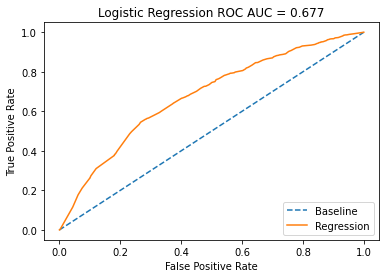

In [34]:
clf_new_new_sm = DecisionTreeClassifier(max_depth=10, random_state=42)
f1['f1_model_clf_new_new_sm'] = mod_check(X_train_smote, y_train_smote, X_test, y_test, clf_new_new_sm)

# Попробуем избавиться от не сильно важных столбцов для упрощения модели

In [35]:
num_cols_light = ['score_bki', 'decline_app_cnt', 'bki_request_cnt']
cat_cols_light = ['education',
 'first_time',
 'sna',
 'work_address',
 'home_address',
 'region_rating']
bin_cols_light = ['foreign_passport']

In [36]:
data_light = data[num_cols_light + cat_cols_light + bin_cols_light + ['sample', 'default']]
data_light[data_light['sample'] == 1].corrwith(data_light[data_light['sample'] == 1]['default']).sort_values()

first_time         -0.105579
region_rating      -0.089035
foreign_passport   -0.066718
bki_request_cnt     0.078501
work_address        0.081582
home_address        0.084637
decline_app_cnt     0.124027
sna                 0.125832
score_bki           0.175369
default             1.000000
sample                   NaN
dtype: float64

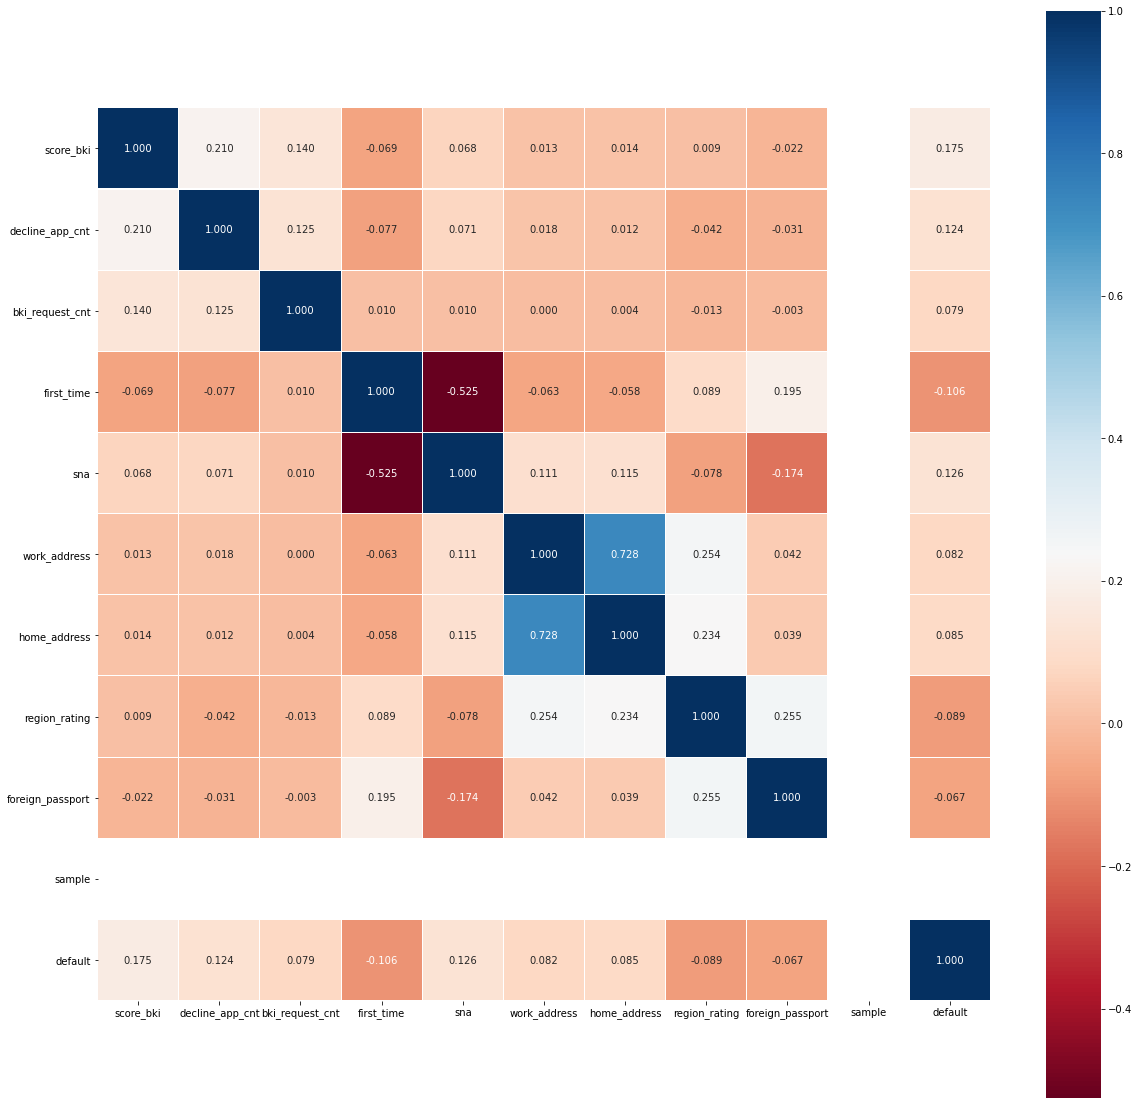

In [37]:
plt.subplots(figsize=(20, 20))
sns.heatmap(data_light[data['sample'] == 1].corr(), square=True,
              annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu")
plt.show()

In [38]:
data_light.drop(['work_address', 'first_time'], axis = 1, inplace = True)

C:\Users\Marina\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [39]:
cat_cols_light = ['education',
 'sna',
 'home_address',
 'region_rating']

In [40]:
train_data_light = data_light.query('sample == 1').drop(['sample'], axis=1)
test_data_light = data_light.query('sample == 0').drop(['sample', 'default'], axis=1)

y_l = train_data_light['default'].values  # наш таргет
X_l = train_data_light.drop(['default'], axis=1)

In [41]:
D_encoder_light = OneHotEncoder(sparse = False)
D_encoder_light.fit(X_l[cat_cols_light].values)
X_cat_l = D_encoder_light.transform(X_l[cat_cols_light].values)

In [42]:
# Стандартизация числовых переменных
scaler_light = StandardScaler()
scaler_light.fit(X_l[num_cols_light].values)

X_num_l = scaler_light.transform(X_l[num_cols_light].values)

In [43]:
X_l = np.hstack([X_num_l, X_l[bin_cols_light].values, X_cat_l])
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_l, y_l, test_size=0.2, random_state=42)
X_train_l, y_train_l = sm.fit_resample(X_train_l, y_train_l)

TreeClassifier



Metrics for model:
DecisionTreeClassifier(max_depth=10, random_state=42) 


Отчет по обучению самой модели:
              precision    recall  f1-score   support

           0       0.71      0.72      0.71     51494
           1       0.72      0.70      0.71     51494

    accuracy                           0.71    102988
   macro avg       0.71      0.71      0.71    102988
weighted avg       0.71      0.71      0.71    102988



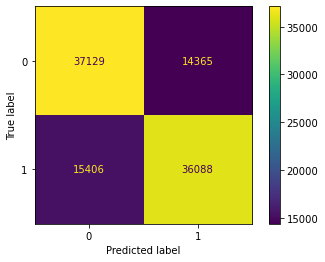


Отчет по реализации модели:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80     12933
           1       0.22      0.58      0.32      1827

    accuracy                           0.69     14760
   macro avg       0.57      0.64      0.56     14760
weighted avg       0.84      0.69      0.74     14760



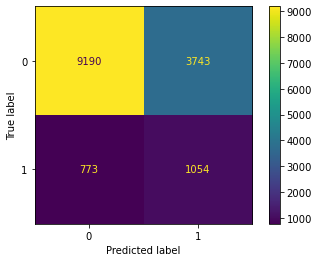

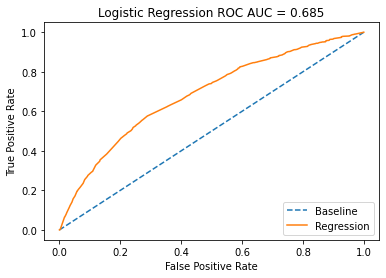

In [44]:
clf_light = DecisionTreeClassifier(max_depth=10, random_state=42)
f1['f1_model_clf_light'] = mod_check(X_train_l, y_train_l, X_test_l, y_test_l, clf_light)

LogisticRegression



Metrics for model:
LogisticRegression(max_iter=1000, solver='liblinear') 


Отчет по обучению самой модели:
              precision    recall  f1-score   support

           0       0.67      0.66      0.67     51494
           1       0.67      0.67      0.67     51494

    accuracy                           0.67    102988
   macro avg       0.67      0.67      0.67    102988
weighted avg       0.67      0.67      0.67    102988



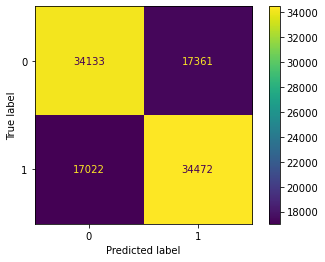


Отчет по реализации модели:
              precision    recall  f1-score   support

           0       0.93      0.66      0.77     12933
           1       0.22      0.67      0.33      1827

    accuracy                           0.66     14760
   macro avg       0.58      0.67      0.55     14760
weighted avg       0.85      0.66      0.72     14760



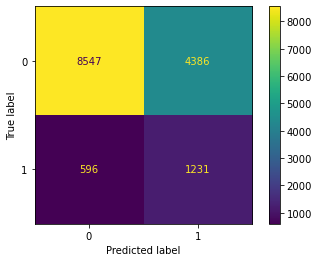

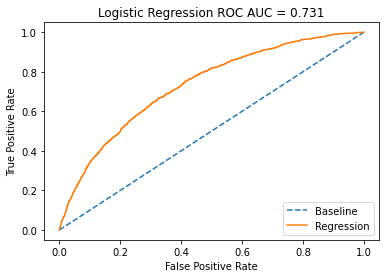

In [45]:
logreg_light = LogisticRegression(solver='liblinear', max_iter=1000)
f1['f1_model_logreg_light'] = mod_check(X_train_l, y_train_l, X_test_l, y_test_l, logreg_light)

LogisticRegression with SMOTE



Metrics for model:
LogisticRegression(max_iter=1000, solver='liblinear') 


Отчет по обучению самой модели:
              precision    recall  f1-score   support

           0       0.67      0.66      0.67     51494
           1       0.67      0.67      0.67     51494

    accuracy                           0.67    102988
   macro avg       0.67      0.67      0.67    102988
weighted avg       0.67      0.67      0.67    102988



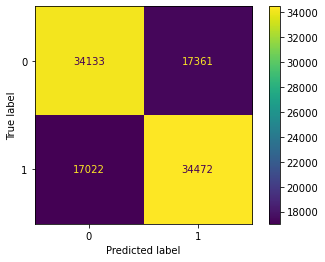


Отчет по реализации модели:
              precision    recall  f1-score   support

           0       0.93      0.66      0.77     12933
           1       0.22      0.67      0.33      1827

    accuracy                           0.66     14760
   macro avg       0.58      0.67      0.55     14760
weighted avg       0.85      0.66      0.72     14760



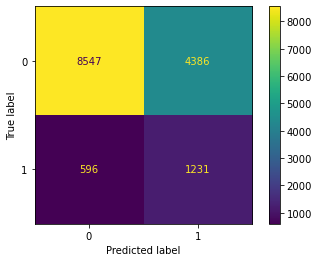

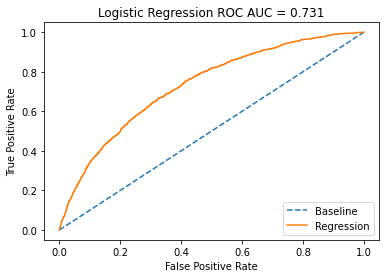

In [46]:
X_train_smote_l, y_train_smote_l = sm.fit_resample(X_train_l, y_train_l)
logreg_smote_lite = LogisticRegression(solver='liblinear', max_iter=1000)
f1['f1_model_logreg_sm_light'] = mod_check(X_train_smote_l, y_train_smote_l, X_test_l, y_test_l, logreg_smote_lite)

Logistic Regression with Post Predict

              precision    recall  f1-score   support

           0       0.93      0.66      0.77     12933
           1       0.22      0.67      0.33      1827

    accuracy                           0.66     14760
   macro avg       0.58      0.67      0.55     14760
weighted avg       0.85      0.66      0.72     14760



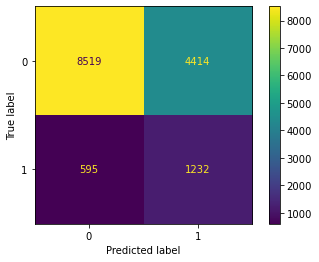

In [47]:
train_data_light['proba'] = logreg_light.predict_proba(X_l)[:,1]
train_data_light['predict'] = logreg_light.predict(X_l)

treshold = (train_data_light[train_data_light['default'] == 1]['proba'].mean() + train_data_light[train_data_light['default'] == 0]['proba'].mean()) / 2

predict_proba_l = logreg_light.predict_proba(X_test_l)[:, 1]
predict_l = []
for item in predict_proba_l:
    if item > treshold:
        predict_l.append(1)
    else:
        predict_l.append(0)
classification_report_l = metrics.classification_report(y_test_l, predict_l)
print(classification_report_l)
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test_l, predict_l))
disp.plot()
plt.show()
f1['f1_model_logreg_post_light'] = metrics.f1_score(y_test_l, predict_l)

# Выбираем лучшую модель

In [48]:
f1

{'f1_model_logreg': 0.042708333333333334,
 'f1_model_logreg_post': 0.3490566037735849,
 'f1_model_logreg_sm': 0.3363881401617251,
 'f1_model_clf': 0.21468926553672316,
 'f1_model_clf_new_new_sm': 0.3153123988345743,
 'f1_model_clf_light': 0.3182367149758454,
 'f1_model_logreg_light': 0.330736163353036,
 'f1_model_logreg_sm_light': 0.330736163353036,
 'f1_model_logreg_post_light': 0.32972032650876487}

# По результатм метрик выбираем логическую регрессию с постпредсказанием

In [49]:
logreg.fit(X, y)

LogisticRegression(max_iter=1000, solver='liblinear')

In [50]:
X_test = test_data

In [51]:
X_test_cat = D_encoder.transform(X_test[cat_cols].values)
X_test_num = scaler.transform(X_test[num_cols].values)
X_test = np.hstack([X_test_num, X_test[bin_cols].values, X_test_cat])

In [52]:
predict_proba = logreg.predict_proba(X_test)[:, 1]
predict = []
for item in predict_proba:
    if item > treshold:
        predict.append(1)
    else:
        predict.append(0)

In [53]:
sample_submission['default'] = predict
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,0
2,75683,0
3,26883,0
4,28862,0
5,99881,0
6,26630,0
7,79934,0
8,16605,0
9,105449,0


# Выводы

1. В решении представлено исследование нескольких моделей для предсказания дефолта клиентов банка.
2. В представленном решении качество предсказания определяется по метрике f-score. Однако для банка скорре более показательна Precision — метрика, измеряющая, насколько много из принятых моделью положительных объектов в действительности являются положительными, т.к. выдать кредит человеку с потенциальным default критично. По этой метрике модель "SVM model with SMOTE" является оптимальной.
3. Из-за достаточно времязатратного процесса обработки модели "SVM model with SMOTE", модель не просчитывается в данном решении. По ней были проведены расчеты, приведем только их результаты:
   - TP 8446, FN 555, FP 4487, TN 1272
   - f1-score 0.77, 0.34
   - recall 0.65, 0.7
   - precision 0.94, 0.22
4. При уменьшени размера ДФ путем избавления от данных со слабой корреляцией с предсказываемой переменной, результаты метрик моделей не улучшились. Чтобы не загромождать код, данное исследование не было представлено на kaggle, но будет отображено в ноутбуке к итоговому заданию.